## **EXP2 Predicting Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP2 analysis and results. Files used were created in preprocessing/EXP2_pseudos notebook.*

**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

The residual is calculated in three different ways named: Residual (comparing NNLS calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
SVD, PCA, ICA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP1.py file and can be run through paperpill using run_EXP1.sh file.

In [2]:
#####################
### set the study ###
#####################
#paths:
res_name = f"MCT_pbmc_EXP2"
pseudo_name = "MCT_pbmc_EXP1"
files_path = "/../data/EXP1/"
cibersort_files = "/../data/EXP1/cibersort/CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_phenoclasses.CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_refsample.bm.K999.txt"
noise_type = "nonoise"
###### set your random seed, num missing cells, and num_samples for reference for reproducibility
random_seed = 88
prop_type = "random"
num_missing_cells = [0, 1, 2, 3, 4]
num_samples = 10000
#how to handle negative residual distribution for NMF
nmf_cut = "minimum_value"
kerne_name = "env_ml"

In [3]:
#parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"

Import the previously processed datasets. 

*See preprocessing/EXP1_pseudos.ipynb notebook for details.*

In [4]:
#and as anndata object
adata_path = os.path.join(path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata

AnnData object with n_obs × n_vars = 2589 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'scpred_CellType', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
Counter(sn_adata.obs["cell_types"])

Counter({'FCGR3A Monocytes': 163,
         'B': 342,
         'CD4 T': 1131,
         'NK': 200,
         'CD8 T': 317,
         'CD14 Monocytes': 436})

In [6]:
#excluding all cell types except 5 of interest
if pseudo_name == "MCT_snadp_EXP1_5CTnoise" or pseudo_name == "MCT_snadp_EXP1_5CTnonoise": #if pseudos have 5 cell types
    exclude = ['preadipocyte',
        'mesothelial cell',
        'pericyte cell',
        'fat cell',
        'endothelial cell',
        'endothelial cell of lymphatic vessel',
        'smooth muscle cell',
        'mast cell',
        'immature NK T cell',
        'stromal cell of endometrium',
        'neutrophil']
    sn_adata = sn_adata[~sn_adata.obs["cell_types"].isin(exclude), :]
#Tilde is “not”, so this reads like “var names that are not in exclude”
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'CD4 T': 1131, 'CD14 Monocytes': 436, 'B': 342, 'CD8 T': 317, 'NK': 200, 'FCGR3A Monocytes': 163})


Randomly selecting cells to delete:

In [7]:
cells_to_miss = sn_sc_preprocess.select_cells_missing(sn_adata, num_missing_cells, random_seed)
cells_to_miss    

{0: [], 1: [2], 2: [0, 2], 3: [0, 2, 4], 4: [0, 2, 3, 4]}

## Creating reference profiles and Importing Bulks:


1. ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). Once it is clipped and scaled with MinMax(), it becomes:
2. ref_df, which is used in NNLS. 

In [8]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var_names
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw

FCGR3A Monocytes       B   CD4 T      NK   CD8 T  \
AL627309.1                  0.0     0.0    18.0     0.0    34.0   
AP006222.2                  0.0     0.0     8.0     0.0    28.0   
RP11-206L10.2               0.0    62.0    10.0     0.0     0.0   
RP11-206L10.9               0.0     0.0     0.0    43.0     0.0   
LINC00115                  58.0    83.0    52.0    95.0    51.0   
...                         ...     ...     ...     ...     ...   
AC145212.1                  0.0    61.0    34.0   182.0    20.0   
AL592183.1               1312.0  1743.0  1384.0  1244.0  1390.0   
AL354822.1                  0.0    53.0    18.0   140.0     0.0   
PNRC2-1                   618.0   277.0   482.0   421.0   420.0   
SRSF10-1                  114.0   289.0   335.0   486.0   239.0   

               CD14 Monocytes  
AL627309.1              129.0  
AP006222.2               21.0  
RP11-206L10.2             0.0  
RP11-206L10.9            40.0  
LINC00115                98.0  
...                       ...  
AC145212.1              120.0  
AL592183.1              969.0  
AL354822.1               15.0  
PNRC2-1                 271.0  
SRSF10-1                  0.0  

[13714 rows x 6 columns]

In [9]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df

FCGR3A Monocytes         B     CD4 T        NK     CD8 T  \
AL627309.1             0.000000  0.000000  0.004780  0.000000  0.009029   
AP006222.2             0.000000  0.000000  0.002124  0.000000  0.007435   
RP11-206L10.2          0.000000  0.016464  0.002655  0.000000  0.000000   
RP11-206L10.9          0.000000  0.000000  0.000000  0.011418  0.000000   
LINC00115              0.015402  0.022040  0.013808  0.025227  0.013543   
...                         ...       ...       ...       ...       ...   
AC145212.1             0.000000  0.016198  0.009029  0.048329  0.005311   
AL592183.1             0.348394  0.462844  0.367513  0.330337  0.369107   
AL354822.1             0.000000  0.014074  0.004780  0.037176  0.000000   
PNRC2-1                0.164106  0.073556  0.127992  0.111794  0.111529   
SRSF10-1               0.030272  0.076742  0.088957  0.129055  0.063465   

               CD14 Monocytes  
AL627309.1           0.034255  
AP006222.2           0.005576  
RP11-206L10.2        0.000000  
RP11-206L10.9        0.010622  
LINC00115            0.026023  
...                       ...  
AC145212.1           0.031865  
AL592183.1           0.257312  
AL354822.1           0.003983  
PNRC2-1              0.071962  
SRSF10-1             0.000000  

[13714 rows x 6 columns]

Importing Bulks:

In [10]:
#each pseudo file has:
## realisitc*200, cell_type_specific*1000*, random*200, equal*200
#so here we're defining the ranges to extract the bulks of choice.
bulk_range = dict()
bulk_range["realistic"] = range(0,200)
bulk_range["cell_type_specific"] = range(200,(50*num_cells)+200) #1000
bulk_range["random"] = range((50*num_cells)+200,(50*num_cells)+400) #1200
bulk_range["equal"] = range((50*num_cells)+400,(50*num_cells)+600) #1400
bulk_range["all"] = range(0,(50*num_cells)+600)

In [11]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

900

In [12]:
#importing bulks to deconvolve
X_full, Y_full, gene_df, meta_df = sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type= f"{noise_type}_", file_name = pseudo_name, num_bulks_training = num_bulks, num_files=10, random_selection=False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_11565/1540599639.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


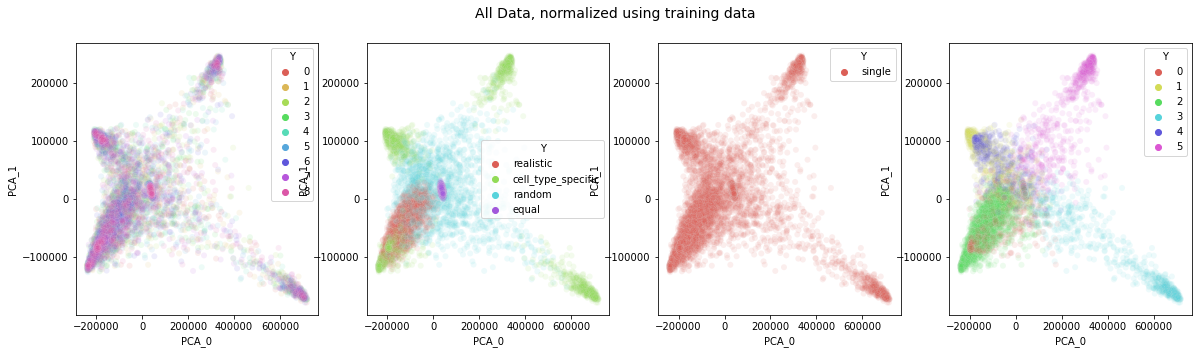

In [13]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

In [14]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == prop_type)[0]
pseudo_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudo_df.index = range(0,len(pseudo_df))
prop_df.index = pseudo_df.index
meta_df.index = meta_df.index
pseudo_df.columns = sn_adata.var_names
pseudo_df

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  NOC2L  \
0           20.0         9.0            7.0           13.0       32.0  509.0   
1           36.0         6.0            3.0           11.0       46.0  543.0   
2           10.0         1.0            3.0            2.0       38.0  450.0   
3           18.0         3.0            3.0           17.0       39.0  732.0   
4            9.0         4.0            1.0           11.0       37.0  536.0   
...          ...         ...            ...            ...        ...    ...   
1995        25.0         6.0            5.0            8.0       49.0  524.0   
1996        19.0         8.0           15.0            3.0       49.0  544.0   
1997         4.0         2.0            4.0           31.0       44.0  738.0   
1998         7.0         3.0            3.0            1.0       35.0  612.0   
1999        16.0        10.0            3.0           12.0       36.0  542.0   

      KLHL17  PLEKHN1  RP11-54O7.17    HES4  ...  MT-ND4L   MT-ND4  MT-ND5  \
0       12.0     13.0           7.0   300.0  ...    761.0  23559.0  4110.0   
1       15.0     17.0          19.0   500.0  ...    750.0  23690.0  4139.0   
2        6.0     17.0           3.0   261.0  ...    838.0  28137.0  4770.0   
3       17.0     12.0          10.0  1806.0  ...    818.0  28487.0  5593.0   
4       18.0     16.0          10.0   950.0  ...    828.0  29637.0  5080.0   
...      ...      ...           ...     ...  ...      ...      ...     ...   
1995    16.0     20.0           7.0   356.0  ...    825.0  24748.0  4363.0   
1996    17.0     10.0          11.0   333.0  ...    702.0  22518.0  3633.0   
1997    27.0      5.0          19.0  2451.0  ...    924.0  29978.0  6034.0   
1998    15.0     22.0           0.0   388.0  ...    829.0  25780.0  4161.0   
1999    26.0      8.0           7.0   768.0  ...    835.0  26572.0  4620.0   

      MT-ND6   MT-CYB  AC145212.1  AL592183.1  AL354822.1  PNRC2-1  SRSF10-1  
0      518.0  21025.0        40.0       662.0        11.0    199.0      96.0  
1      509.0  20515.0        43.0       604.0        20.0    164.0     106.0  
2      711.0  25316.0        22.0       615.0         6.0    242.0      83.0  
3      564.0  24353.0        48.0       660.0        39.0    208.0     143.0  
4      697.0  25918.0        39.0       659.0        28.0    217.0     134.0  
...      ...      ...         ...         ...         ...      ...       ...  
1995   527.0  22015.0        33.0       639.0        17.0    210.0      94.0  
1996   426.0  18567.0        24.0       706.0        22.0    181.0     103.0  
1997   532.0  24614.0        81.0       646.0        52.0    199.0     214.0  
1998   574.0  21737.0        20.0       662.0        11.0    224.0     156.0  
1999   510.0  23087.0        38.0       631.0        21.0    227.0     144.0  

[2000 rows x 13714 columns]

In [15]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudo_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudo_df = pseudo_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudo_df

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  NOC2L  \
1059         2.0         2.0            9.0            5.0       45.0  601.0   
929         16.0         3.0            3.0            3.0       39.0  540.0   
1506         5.0         0.0            2.0           13.0       34.0  671.0   
237         13.0         5.0            1.0            8.0       40.0  473.0   
1371         8.0         2.0           14.0           10.0       50.0  634.0   
...          ...         ...            ...            ...        ...    ...   
1573         5.0         2.0            4.0           18.0       47.0  687.0   
1132         2.0         6.0            4.0           14.0       39.0  650.0   
1998         7.0         3.0            3.0            1.0       35.0  612.0   
1988        16.0         4.0            7.0           10.0       37.0  556.0   
1167        10.0         3.0            3.0            7.0       31.0  593.0   

      KLHL17  PLEKHN1  RP11-54O7.17    HES4  ...  MT-ND4L   MT-ND4  MT-ND5  \
1059     9.0     10.0           8.0  1192.0  ...    782.0  27611.0  4719.0   
929     15.0     14.0           4.0   305.0  ...    833.0  25361.0  4441.0   
1506    11.0     12.0          13.0  1772.0  ...    882.0  29154.0  5604.0   
237     14.0     22.0           8.0   357.0  ...    833.0  28217.0  4871.0   
1371    15.0      5.0           4.0  1057.0  ...    783.0  25745.0  4473.0   
...      ...      ...           ...     ...  ...      ...      ...     ...   
1573    15.0      4.0          10.0  2143.0  ...    888.0  29356.0  5643.0   
1132    10.0     15.0          13.0  1578.0  ...    826.0  28041.0  5171.0   
1998    15.0     22.0           0.0   388.0  ...    829.0  25780.0  4161.0   
1988    13.0      8.0           5.0  1035.0  ...    883.0  27069.0  4973.0   
1167    14.0     14.0           6.0   669.0  ...    785.0  25106.0  4462.0   

      MT-ND6   MT-CYB  AC145212.1  AL592183.1  AL354822.1  PNRC2-1  SRSF10-1  
1059   441.0  22344.0        48.0       754.0        31.0    156.0     145.0  
929    598.0  22413.0        13.0       666.0         8.0    239.0     125.0  
1506   528.0  24700.0        69.0       666.0        40.0    182.0     177.0  
237    679.0  25274.0        19.0       637.0        18.0    232.0      96.0  
1371   450.0  21134.0        44.0       814.0        27.0    216.0     165.0  
...      ...      ...         ...         ...         ...      ...       ...  
1573   536.0  24252.0        52.0       640.0        50.0    218.0     199.0  
1132   563.0  23493.0        56.0       725.0        43.0    246.0     176.0  
1998   574.0  21737.0        20.0       662.0        11.0    224.0     156.0  
1988   557.0  22930.0        41.0       653.0        20.0    221.0     130.0  
1167   549.0  21949.0        39.0       722.0        24.0    231.0     131.0  

[1000 rows x 13714 columns]

In [16]:
#clippign before scaling to 95th pecentile
pseudo_copy = pseudo_df.copy() #keeping genes
pseudo_df = pseudo_df.values #np array
clip_upper = np.quantile(pseudo_df, 0.95)
pseudo_df = np.clip(pseudo_df, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(pseudo_df)
normalized_pseudo_df = scaler.transform(pseudo_df)
normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_pseudo_df      

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  \
1059    0.028571        0.10       0.310345           0.20   0.613636   
929     0.228571        0.15       0.103448           0.12   0.477273   
1506    0.071429        0.00       0.068966           0.52   0.363636   
237     0.185714        0.25       0.034483           0.32   0.500000   
1371    0.114286        0.10       0.482759           0.40   0.727273   
...          ...         ...            ...            ...        ...   
1573    0.071429        0.10       0.137931           0.72   0.659091   
1132    0.028571        0.30       0.137931           0.56   0.477273   
1998    0.100000        0.15       0.103448           0.04   0.386364   
1988    0.228571        0.20       0.241379           0.40   0.431818   
1167    0.142857        0.15       0.103448           0.28   0.295455   

         NOC2L    KLHL17   PLEKHN1  RP11-54O7.17      HES4  ...   MT-ND4L  \
1059  0.551282  0.300000  0.285714      0.242424  0.618378  ...  0.370482   
929   0.394872  0.500000  0.400000      0.121212  0.138919  ...  0.524096   
1506  0.730769  0.366667  0.342857      0.393939  0.931892  ...  0.671687   
237   0.223077  0.466667  0.628571      0.242424  0.167027  ...  0.524096   
1371  0.635897  0.500000  0.142857      0.121212  0.545405  ...  0.373494   
...        ...       ...       ...           ...       ...  ...       ...   
1573  0.771795  0.500000  0.114286      0.303030  1.000000  ...  0.689759   
1132  0.676923  0.333333  0.428571      0.393939  0.827027  ...  0.503012   
1998  0.579487  0.500000  0.628571      0.000000  0.183784  ...  0.512048   
1988  0.435897  0.433333  0.228571      0.151515  0.533514  ...  0.674699   
1167  0.530769  0.466667  0.400000      0.181818  0.335676  ...  0.379518   

      MT-ND4  MT-ND5    MT-ND6  MT-CYB  AC145212.1  AL592183.1  AL354822.1  \
1059     0.0     0.0  0.235067     0.0    0.484211    0.728997    0.397436   
929      0.0     0.0  0.537572     0.0    0.115789    0.490515    0.102564   
1506     0.0     0.0  0.402697     0.0    0.705263    0.490515    0.512821   
237      0.0     0.0  0.693642     0.0    0.178947    0.411924    0.230769   
1371     0.0     0.0  0.252408     0.0    0.442105    0.891599    0.346154   
...      ...     ...       ...     ...         ...         ...         ...   
1573     0.0     0.0  0.418112     0.0    0.526316    0.420054    0.641026   
1132     0.0     0.0  0.470135     0.0    0.568421    0.650407    0.551282   
1998     0.0     0.0  0.491329     0.0    0.189474    0.479675    0.141026   
1988     0.0     0.0  0.458574     0.0    0.410526    0.455285    0.256410   
1167     0.0     0.0  0.443160     0.0    0.389474    0.642276    0.307692   

       PNRC2-1  SRSF10-1  
1059  0.146226  0.526549  
929   0.537736  0.438053  
1506  0.268868  0.668142  
237   0.504717  0.309735  
1371  0.429245  0.615044  
...        ...       ...  
1573  0.438679  0.765487  
1132  0.570755  0.663717  
1998  0.466981  0.575221  
1988  0.452830  0.460177  
1167  0.500000  0.464602  

[1000 rows x 13714 columns]

In [17]:
# read in cibersort genes 
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()
#and set intersection of gene_ids and cibersort:
gene_notin = np.setdiff1d(gene_ids, cibersort_genes)
#keep genes in both and check number
gene_ids = [ele for ele in gene_ids if ele not in gene_notin]
len(gene_ids)     

1600

In [18]:
#cutting to cibersort genes 
pseudo_copy  = pseudo_copy[gene_ids]
ref_raw = ref_raw.loc[gene_ids,:]
ref_df = ref_df.loc[gene_ids,:]
normalized_pseudo_df = normalized_pseudo_df[gene_ids]
normalized_pseudo_df

HES4     MXRA8      NADK     MEGF6    CEP104    KCNAB2   DNAJC11  \
1059  0.618378  0.083333  0.333717  0.214286  0.477064  0.324528  0.303419   
929   0.138919  0.458333  0.146145  0.809524  0.348624  0.269811  0.363248   
1506  0.931892  0.166667  0.504028  0.142857  0.412844  0.575472  0.611111   
237   0.167027  0.291667  0.113924  0.595238  0.743119  0.320755  0.564103   
1371  0.545405  0.166667  0.368239  0.214286  0.348624  0.347170  0.277778   
...        ...       ...       ...       ...       ...       ...       ...   
1573  1.000000  0.375000  0.589183  0.285714  0.477064  0.628302  0.619658   
1132  0.827027  0.208333  0.454545  0.309524  0.614679  0.483019  0.470085   
1998  0.183784  0.541667  0.109321  0.619048  0.284404  0.188679  0.235043   
1988  0.533514  0.208333  0.317606  0.452381  0.477064  0.464151  0.371795   
1167  0.335676  0.041667  0.224396  0.380952  0.302752  0.339623  0.457265   

      ENO1      H6PD  CTNNBIP1  ...      ETS2  HMGN1     BACE2       MX2  \
1059   0.0  0.329843  0.290323  ...  0.293930    0.0  0.279320  0.269231   
929    0.0  0.204188  0.329749  ...  0.287540    0.0  0.091316  0.339744   
1506   0.0  0.465969  0.482079  ...  0.476038    0.0  0.059087  0.401923   
237    0.0  0.219895  0.362007  ...  0.300319    0.0  0.069830  0.356410   
1371   0.0  0.324607  0.392473  ...  0.386581    0.0  0.324978  0.242308   
...    ...       ...       ...  ...       ...    ...       ...       ...   
1573   0.0  0.570681  0.571685  ...  0.594249    0.0  0.061773  0.482692   
1132   0.0  0.528796  0.480287  ...  0.520767    0.0  0.056401  0.491026   
1998   0.0  0.141361  0.318996  ...  0.357827    0.0  0.103850  0.253846   
1988   0.0  0.335079  0.575269  ...  0.476038    0.0  0.105640  0.346795   
1167   0.0  0.350785  0.349462  ...  0.290735    0.0  0.138765  0.266667   

         ABCG1  ITGB2    ADARB1   COL18A1       LSS  AL592183.1  
1059  0.858333    0.0  0.679245  0.300752  0.119266    0.728997  
929   0.650000    0.0  0.301887  0.578947  0.431193    0.490515  
1506  0.700000    0.0  0.311321  0.300752  0.256881    0.490515  
237   0.633333    0.0  0.330189  0.338346  0.284404    0.411924  
1371  0.741667    0.0  0.528302  0.661654  0.238532    0.891599  
...        ...    ...       ...       ...       ...         ...  
1573  0.525000    0.0  0.311321  0.473684  0.192661    0.420054  
1132  0.566667    0.0  0.150943  0.390977  0.266055    0.650407  
1998  0.483333    0.0  0.320755  0.796992  0.366972    0.479675  
1988  0.558333    0.0  0.132075  0.458647  0.229358    0.455285  
1167  0.583333    0.0  0.358491  0.398496  0.266055    0.642276  

[1000 rows x 1600 columns]

TSNEs of Pseuboulks and References:

===> Finding 180 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.56 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 500 iterations...
Iteration   50, KL divergence 0.8500, 50 iterations in 0.2645 sec
Iteration  100, KL divergence 0.8375, 50 iterations in 0.2341 sec
Iteration  150, KL divergence 0.8343, 50 iterations in 0.2465 sec
Iteration  200, KL divergence 0.8340, 50 iterations in 0.2423 sec
Iteration  250, KL divergence 0.8338, 50 iterations in 0.2586 sec
Iteration  300, KL divergence 0.8339, 50 iterations in 0.2445 sec
Iteration  350, KL divergence 0.8338, 50 iterations in 0.2455 sec
Iteration  400, KL divergence 0.8335, 50 iterations in 0.2483 sec
Iteration  450, KL divergence 0.8337, 50 iterations in 0.2445 sec
Iteration  500, KL divergence 0.8338, 50 iterations in 0.2415 sec
   --> Time elapsed: 2.47 seconds
===> Finding 15 nearest n

Perplexity value 60 is too high. Using perplexity 1.67 instead


Iteration  200, KL divergence 9036.5007, 50 iterations in 0.0465 sec
Iteration  250, KL divergence 9032.0137, 50 iterations in 0.0387 sec
   --> Time elapsed: 0.22 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 23.7939, 50 iterations in 0.0217 sec
Iteration  100, KL divergence 23.7695, 50 iterations in 0.0200 sec
Iteration  150, KL divergence 23.7670, 50 iterations in 0.0199 sec
Iteration  200, KL divergence 23.7667, 50 iterations in 0.0189 sec
Iteration  250, KL divergence 23.7667, 50 iterations in 0.0203 sec
   --> Time elapsed: 0.10 seconds
===> Finding 5 nearest neighbors using exact search using euclidean dista

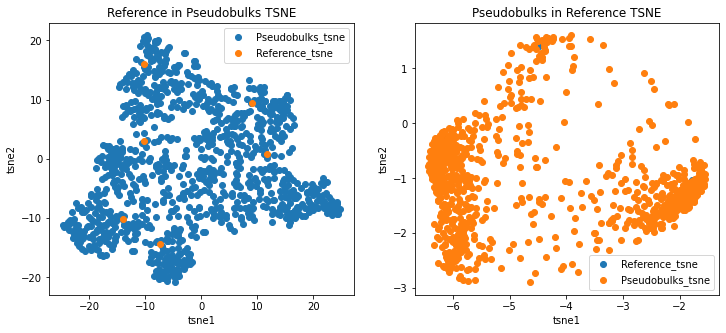

In [19]:
#tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
#figures
plt.figure(figsize=(12, 5))
#data used
x_train = normalized_pseudo_df.values
x_test = ref_df.T.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 1)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
plt.title(f"Reference in Pseudobulks TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
#data used (switching)
x_train = ref_df.T.values
x_test = normalized_pseudo_df.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 2)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Pseudobulks_tsne" )
plt.title(f"Pseudobulks in Reference TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
plt.show()

In [20]:
# Putting together all reference expression, scaled and unscaled, and props.
all_refs = dict()
all_prop_refs = dict()
all_prop_refs_rebalanced = dict()
all_refs_raw = dict()
all_refs_av = dict()
#with no cell missing is just ref_df
all_refs[0] = ref_df
all_refs_raw[0] = ref_raw
all_prop_refs[0] = prop_df
all_prop_refs_rebalanced[0] = prop_df
#assigning the rest in a loop
for num in num_missing_cells[1:]:
    #dropping cell types missing from references
    all_refs[num] = ref_df.drop(ref_df.columns[cells_to_miss[num]], axis=1)
    all_refs_raw[num] = ref_raw.drop(ref_raw.columns[cells_to_miss[num]], axis=1)
    all_prop_refs[num] = prop_df.drop(prop_df.columns[cells_to_miss[num]], axis=1) 
    all_prop_refs_rebalanced[num] = all_prop_refs[num]
    for idx,sample in all_prop_refs_rebalanced[num].iterrows():
        tot = np.sum(sample) #making them equal 1
        sample = sample / tot

## NNLS Deconvolution:

In [21]:
calc_prop_tot, calc_res_tot, custom_res_tot, comparison_prop_tot, missing_cell_tot  = vp.calc_nnls(all_refs, prop_df, normalized_pseudo_df, num_missing_cells, cells_to_miss)

Exp 0
Exp 1
Exp 2
Exp 3
Exp 4


Evalutating NNLS Performance:

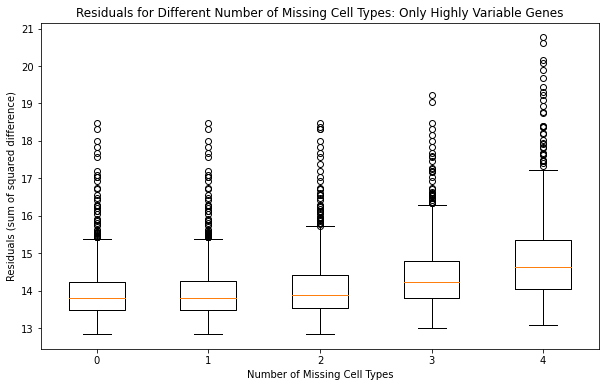

In [22]:
#Distribution of residuals as the sum of squared difference from NNLS
residuals = [calc_res_tot[exp] for exp in num_missing_cells]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=num_missing_cells)
plt.xlabel('Number of Missing Cell Types')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Different Number of Missing Cell Types: Only Highly Variable Genes')
## nnls(A, b)
## /Ax -b/^2
plt.show()

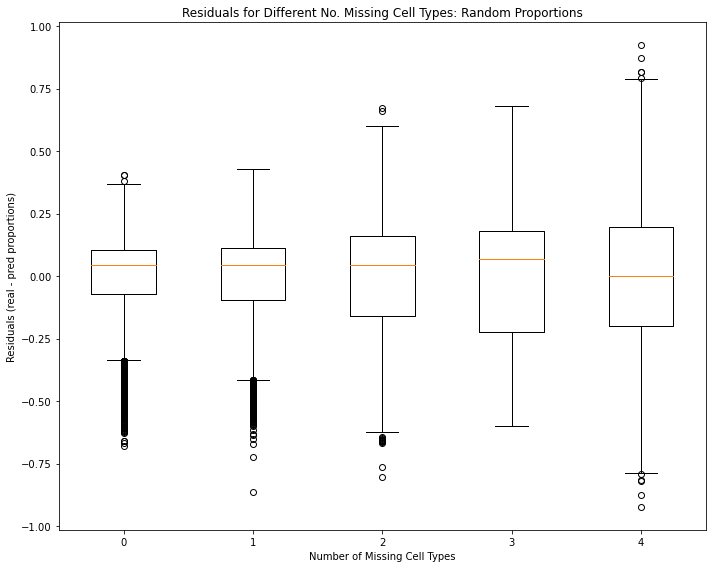

In [23]:
#Distribution of residuals as the difference between calculated and real proportions.
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

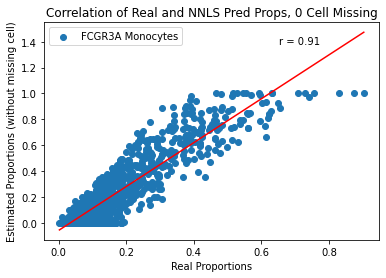

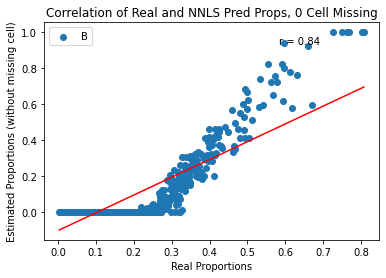

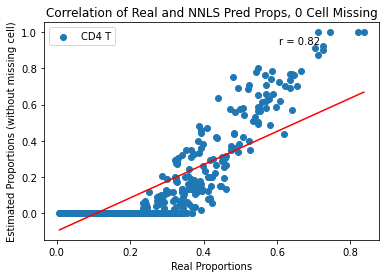

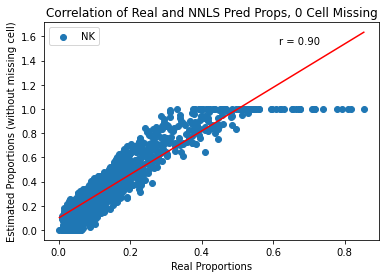

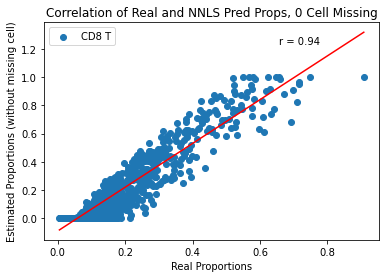

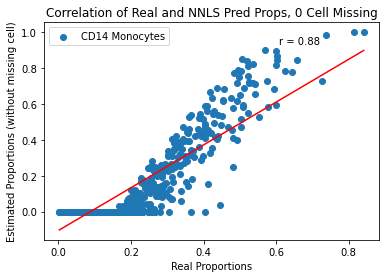

In [24]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in all_prop_refs[num].columns:
    x = all_prop_refs_rebalanced[num][col_cell].values.astype(float)
    y = calc_prop_tot[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 6)
Estimated Proportions shape: (1000, 6)


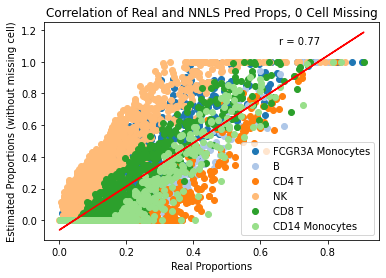

Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


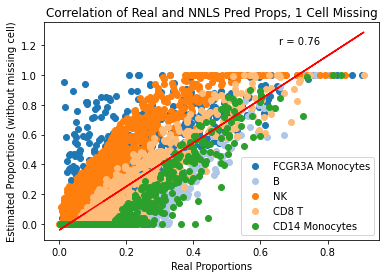

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


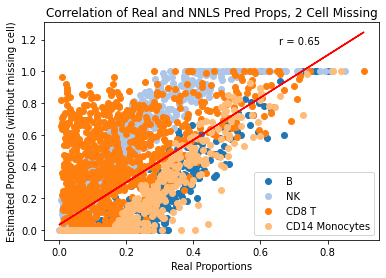

Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


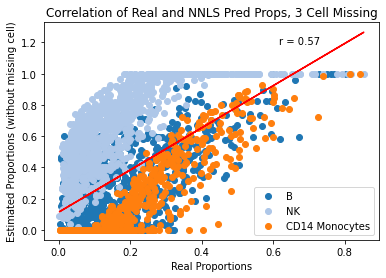

Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


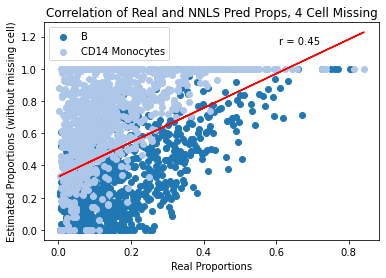

In [25]:
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
for num in num_missing_cells:
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float) #real proportions of present cells
    estimated_proportions = calc_prop_tot[num].values.astype(float) #estimated proportions of present cells.
    cell_types = all_prop_refs[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        color = cmap(i)  #unique color for each cell type
        ax.scatter(x, y, label=cell_type, color=color)
    #fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='best')  #show the cell type labels in the legend
    plt.show()

Recreate Matrices:

In [26]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(all_refs[num] @ calc_prop_tot[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids
recreated_mat_all[0]    

HES4     MXRA8      NADK     MEGF6    CEP104    KCNAB2   DNAJC11  \
0    0.621123  0.000000  0.384516  0.000492  0.081946  0.390963  0.091156   
1    0.186185  0.001306  0.150786  0.011217  0.083916  0.323202  0.114816   
2    0.842773  0.000000  0.502173  0.002418  0.087159  0.480598  0.134170   
3    0.161863  0.000000  0.128549  0.012888  0.094323  0.329789  0.144824   
4    0.616241  0.000000  0.390326  0.000000  0.080811  0.396765  0.087330   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.000000  0.000000  0.588446  0.000000  0.085505  0.515421  0.131710   
996  0.787429  0.000000  0.474156  0.002845  0.087046  0.467944  0.131606   
997  0.170076  0.006721  0.128805  0.015104  0.056820  0.278443  0.065240   
998  0.722764  0.000000  0.436323  0.004263  0.088422  0.454019  0.136048   
999  0.411543  0.000000  0.291555  0.004360  0.083993  0.380702  0.102965   

     ENO1      H6PD  CTNNBIP1  ...      ETS2  HMGN1     BACE2       MX2  \
0     1.0  0.090324  0.211649  ...  0.129572    1.0  0.228341  0.567955   
1     1.0  0.051359  0.171255  ...  0.081924    1.0  0.005829  0.678004   
2     1.0  0.110777  0.289375  ...  0.178823    1.0  0.022759  0.808129   
3     1.0  0.048874  0.163732  ...  0.083855    1.0  0.004023  0.826865   
4     1.0  0.090212  0.221602  ...  0.129036    1.0  0.185167  0.552438   
..    ...       ...       ...  ...       ...    ...       ...       ...   
995   1.0  0.125071  0.318388  ...  0.200751    1.0  0.027086  0.803803   
996   1.0  0.105814  0.279964  ...  0.170176    1.0  0.021514  0.792746   
997   1.0  0.049586  0.163827  ...  0.077356    1.0  0.004180  0.423859   
998   1.0  0.099867  0.267231  ...  0.162085    1.0  0.019457  0.811431   
999   1.0  0.072324  0.218665  ...  0.108409    1.0  0.013971  0.632949   

        ABCG1     ITGB2    ADARB1   COL18A1       LSS  AL592183.1  
0    0.055287  0.860125  0.044029  0.025842  0.002661    0.378346  
1    0.053214  1.000000  0.029726  0.017846  0.012908    0.350331  
2    0.040813  1.000000  0.028773  0.021867  0.000000    0.333221  
3    0.057712  1.000000  0.032630  0.003865  0.000000    0.345712  
4    0.051294  0.889293  0.039377  0.026550  0.010187    0.372144  
..        ...       ...       ...       ...       ...         ...  
995  0.036911  1.000000  0.027882  0.026023  0.000000    0.330337  
996  0.041621  1.000000  0.028642  0.021132  0.002039    0.334809  
997  0.049506  1.000000  0.027798  0.057205  0.023042    0.359432  
998  0.043791  1.000000  0.029453  0.018694  0.000000    0.335423  
999  0.045256  1.000000  0.026301  0.018527  0.022557    0.347471  

[1000 rows x 1600 columns]

## **Extracting Missing Cell Information:**

In [27]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = prop_df[missing_cell_tot[num].columns]  

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))



In [28]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = normalized_pseudo_df.values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids)
residuals[0]    

HES4     MXRA8      NADK     MEGF6    CEP104    KCNAB2   DNAJC11  \
0   -2.744482e-03  0.083333 -0.050799  0.213793  0.395118 -0.066435  0.212262   
1   -4.726577e-02  0.457027 -0.004641  0.798307  0.264708 -0.053391  0.248432   
2    8.911931e-02  0.166667  0.001854  0.140439  0.325685  0.094873  0.476941   
3    5.164237e-03  0.291667 -0.014625  0.582350  0.648796 -0.009035  0.419279   
4   -7.083575e-02  0.166667 -0.022087  0.214286  0.267813 -0.049595  0.190448   
..            ...       ...       ...       ...       ...       ...       ...   
995  5.960464e-08  0.375000  0.000737  0.285714  0.391559  0.112880  0.487948   
996  3.959800e-02  0.208333 -0.019610  0.306679  0.527633  0.015075  0.338480   
997  1.370820e-02  0.534946 -0.019484  0.603943  0.227584 -0.089764  0.169803   
998 -1.892502e-01  0.208333 -0.118716  0.448118  0.388642  0.010132  0.235747   
999 -7.586769e-02  0.041667 -0.067159  0.376592  0.218759 -0.041079  0.354300   

     ENO1      H6PD  CTNNBIP1  ...      ETS2  HMGN1     BACE2       MX2  \
0    -1.0  0.239519  0.078674  ...  0.164358   -1.0  0.050978 -0.298724   
1    -1.0  0.152830  0.158494  ...  0.205616   -1.0  0.085487 -0.338261   
2    -1.0  0.355191  0.192703  ...  0.297216   -1.0  0.036328 -0.406206   
3    -1.0  0.171021  0.198275  ...  0.216464   -1.0  0.065807 -0.470455   
4    -1.0  0.234395  0.170871  ...  0.257545   -1.0  0.139811 -0.310130   
..    ...       ...       ...  ...       ...    ...       ...       ...   
995  -1.0  0.445609  0.253297  ...  0.393498   -1.0  0.034687 -0.321110   
996  -1.0  0.422982  0.200322  ...  0.350591   -1.0  0.034887 -0.301721   
997  -1.0  0.091776  0.155170  ...  0.280472   -1.0  0.099669 -0.170013   
998  -1.0  0.235211  0.308038  ...  0.313953   -1.0  0.086183 -0.464636   
999  -1.0  0.278462  0.130797  ...  0.182326   -1.0  0.124793 -0.366282   

        ABCG1     ITGB2    ADARB1   COL18A1       LSS  AL592183.1  
0    0.803047 -0.860125  0.635216  0.274910  0.116605    0.350651  
1    0.596786 -1.000000  0.272161  0.561101  0.418284    0.140184  
2    0.659187 -1.000000  0.282548  0.278885  0.256881    0.157294  
3    0.575621 -1.000000  0.297558  0.334481  0.284404    0.066212  
4    0.690373 -0.889293  0.488925  0.635104  0.228345    0.519454  
..        ...       ...       ...       ...       ...         ...  
995  0.488089 -1.000000  0.283439  0.447661  0.192661    0.089717  
996  0.525046 -1.000000  0.122301  0.369845  0.264016    0.315597  
997  0.433828 -1.000000  0.292957  0.739788  0.343931    0.120242  
998  0.514542 -1.000000  0.102623  0.439953  0.229358    0.119862  
999  0.538078 -1.000000  0.332189  0.379969  0.243498    0.294806  

[1000 rows x 1600 columns]

## **Singular Value Decomposition**

SVD on each residual matrix. For this purposes, we will only focus on U and S.

U: Left singular vectors, representing the column space of the original matrix. (cells)

Σ or sigma: Singular values, representing the diagonal matrix of singular values.

Vh or V^T: Right singular vectors, representing the row space of the original matrix. (sample)

Calculating SVD

In [29]:
num_cells_missing = num_missing_cells #for each number of missing cells
num_celltypes = len(sn_adata.obs['cell_types'].unique())

In [30]:
# SVD on pseudobulk for QC
df = normalized_pseudo_df
Mat_pseudo = df.astype("float32")
U_pseudo, s_pseudo, V_pseudo = sp.linalg.svd(Mat_pseudo)
U_pseudo = pd.DataFrame(U_pseudo)
s_pseudo = pd.DataFrame(s_pseudo)
V_pseudo = pd.DataFrame(V_pseudo)

In [31]:
# SVD on residual 1
U_all = dict()
s_all = dict()
V_all = dict()
Matres_all = dict()

for num in num_cells_missing:
    df = residuals[num]
    Mat = df.astype("float32")
    U, s, V = sp.linalg.svd(Mat)
    U = pd.DataFrame(U)
    s = pd.DataFrame(s)
    V = pd.DataFrame(V)

    U_all[num] = U
    s_all[num] = s
    V_all[num] = V
    Matres_all[num] = Mat

In [32]:
#SVD on reference for QC
U_all_ref = dict()
s_all_ref = dict()
V_all_ref = dict()
Matref_all_ref = dict()

for num in num_cells_missing:
    df = all_refs[num]
    Mat_ref  = df.astype("float32")
    U_ref , s_ref , V_ref  = sp.linalg.svd(Mat_ref )
    U_ref = pd.DataFrame(U_ref )
    s_ref  = pd.DataFrame(s_ref )
    V_ref  = pd.DataFrame(V_ref )

    U_all_ref[num] = U_ref 
    s_all_ref[num] = s_ref 
    V_all_ref[num] = V_ref 
    Matref_all_ref[num] = Mat_ref 

In [33]:
#SVD on recreated matrix for QC
U_all_rec = dict()
s_all_rec = dict()
V_all_rec = dict()
Matres_all_rec = dict()

for num in num_cells_missing:
    df = recreated_mat_all[num]
    Mat_rec = df.astype("float32")
    U_rec , s_rec , V_rec  = sp.linalg.svd(Mat_rec )
    U_rec  = pd.DataFrame(U_rec )
    s_rec  = pd.DataFrame(s_rec )
    V_rec  = pd.DataFrame(V_rec )

    U_all_rec[num] = U_rec 
    s_all_rec[num] = s_rec 
    V_all_rec[num] = V_rec 
    Matres_all_rec[num] = Mat_rec 

S-Value Eval for each SVD:

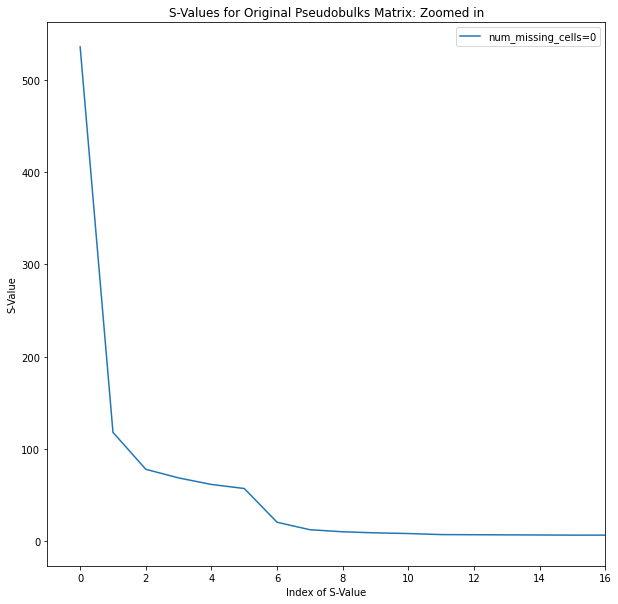

In [34]:
###SVD on Pseudobulk##
num =0
plt.figure(figsize = [10,10])
# Create a color map
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
dataframe = pd.DataFrame(s_pseudo)
x = dataframe.index
y = dataframe.values.flatten()
color = color_map(num_missing_cells.index(num))
label = f"num_missing_cells={num}"
plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Original Pseudobulks Matrix: Zoomed in')
plt.xlim([-1,num_celltypes + 10])
# Add a legend
plt.legend()
# Display the plot
plt.show()

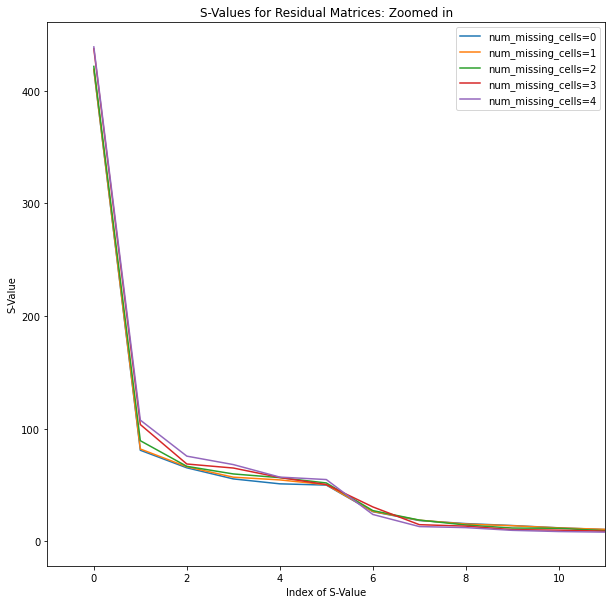

In [35]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating num 
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)
# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Residual Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

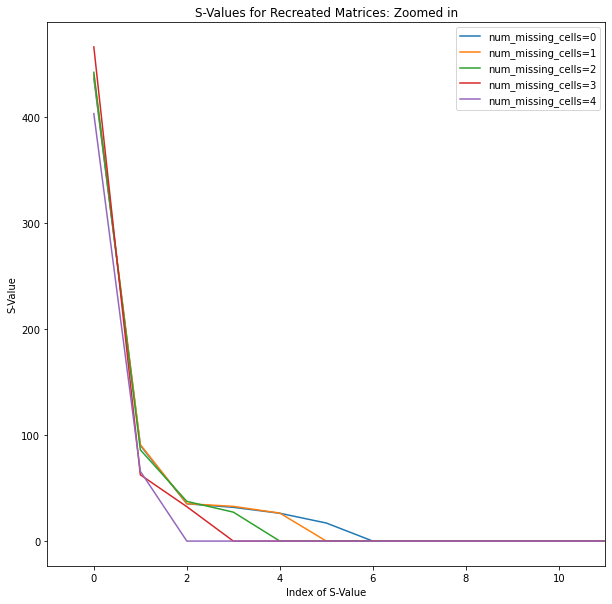

In [36]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_rec[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Recreated Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

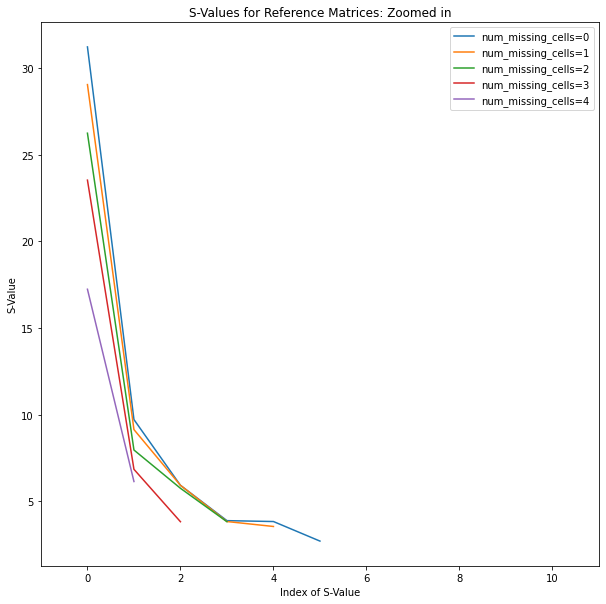

In [37]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_ref[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Reference Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

**Reconstructing Residual Matrix**

In [38]:
#reconstructing SVD using all only some S values, Residual 1.
Recon_Mat_matchS = dict()
for num in num_cells_missing:
    num_SVs = num + 1 #num of comp
    #cutting S and U to 30 to match elbow plots
    U = U_all[num].values[:, :num_SVs]
    S = np.zeros((U.shape[1], Matres_all[num].shape[0]))
    diag_val = s_all[num].values[:num_SVs]
    np.fill_diagonal(S, [diag_val])
    anum = U @ S #reconstructing
    #saving to df dict
    Recon_Mat_matchS[num] = pd.DataFrame(anum[:,0:num_SVs])

**Plotting Correlations between SVD on Residual and Missing Cell Information:**

**Residual** 

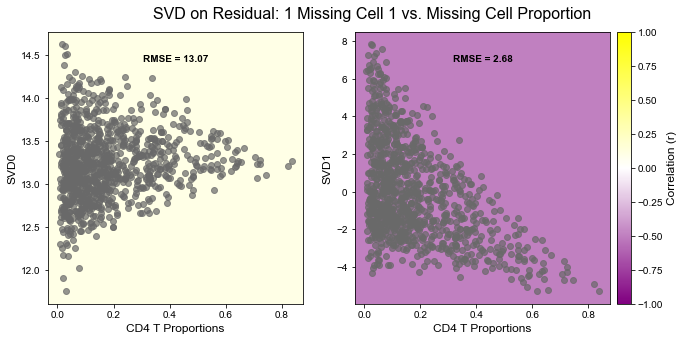

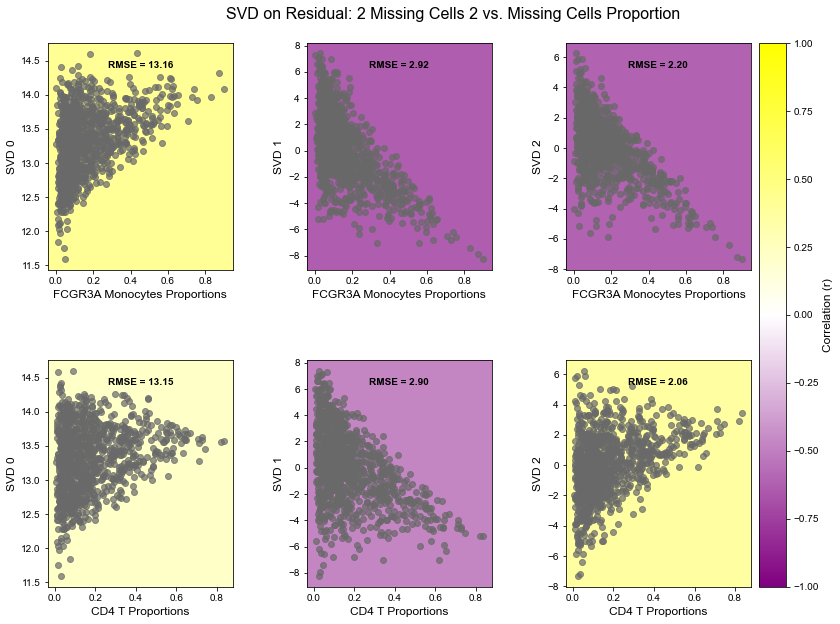

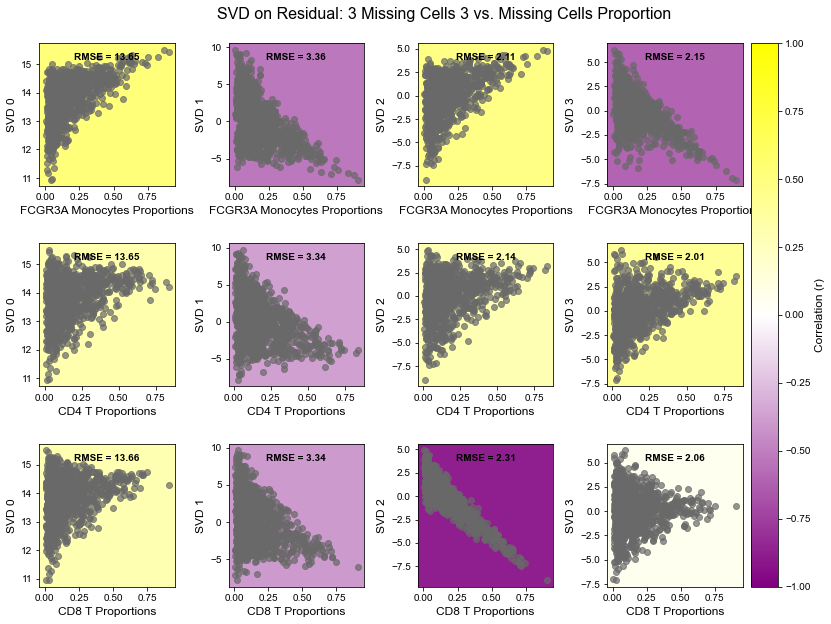

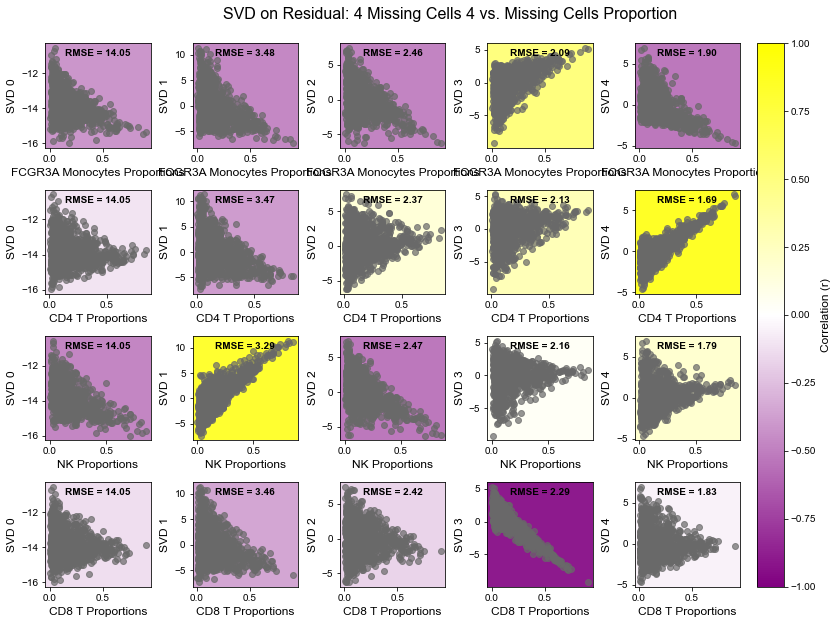

In [39]:
#SVD Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
vp.factors_vs_proportions_rmse(Recon_Mat_matchS, missing_cell_prop, num_missing_cells, "SVD") 
#Each missing cell's expression * proportion matrix is projected into the SVD's reconstructed matrix (just S * U).        

## **PCA**

Calculating PCA for each Residual and Percent of Variance Explained

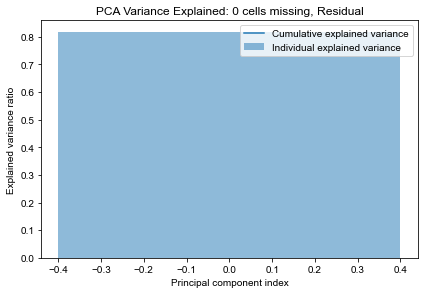

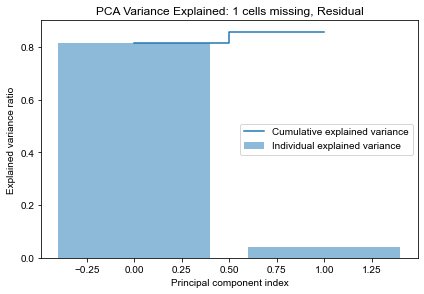

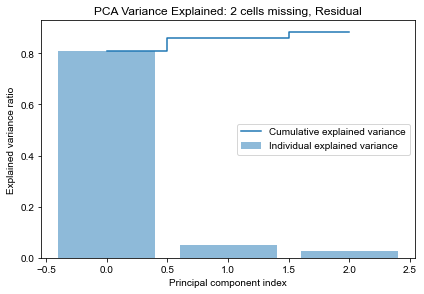

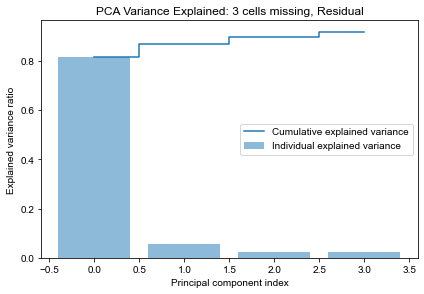

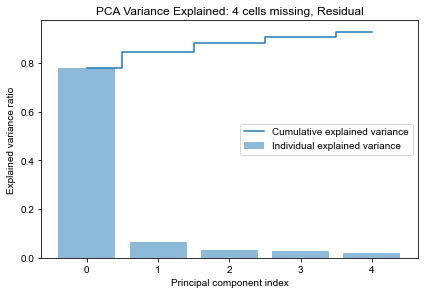

In [40]:
pca_res = dict()
for num in num_cells_missing:
    df = residuals[num].T #transposing to get length of genes instead of samples
    fit = PCA(n_components= num + 1)
    pca_results = fit.fit_transform(df.values)

    exp_var_pca = fit.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    ## plot variance explained
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA Variance Explained: {num} cells missing, Residual")
    plt.show()
    pca_res[num] = pd.DataFrame(pca_results)

Analyzing PCA Results

Residual

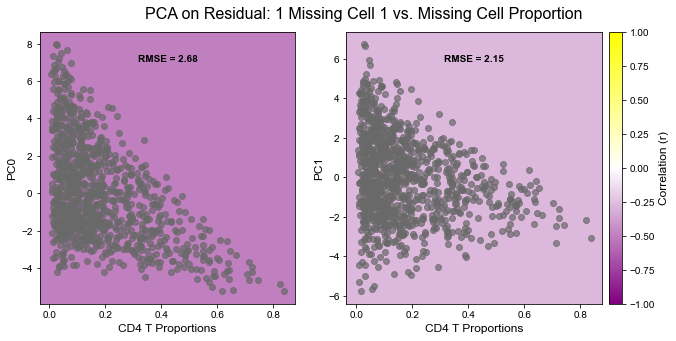

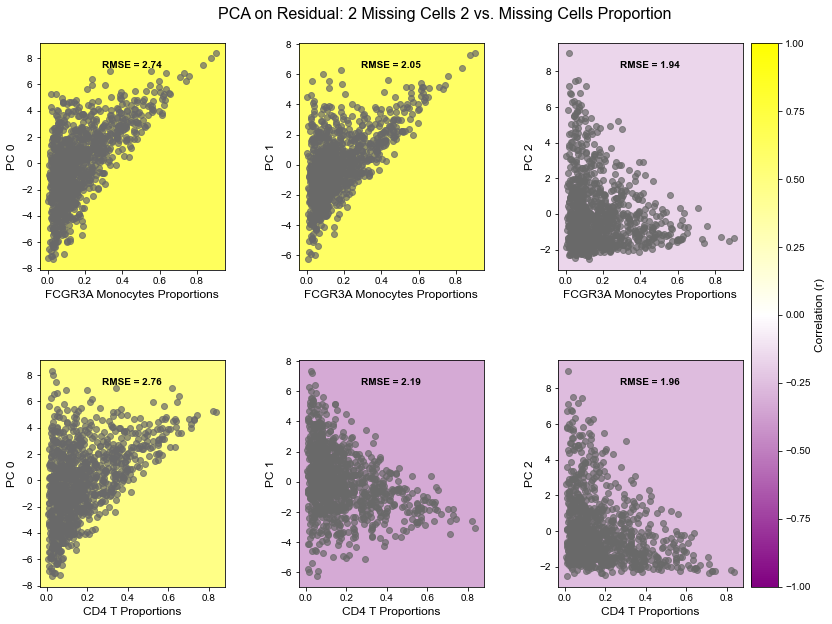

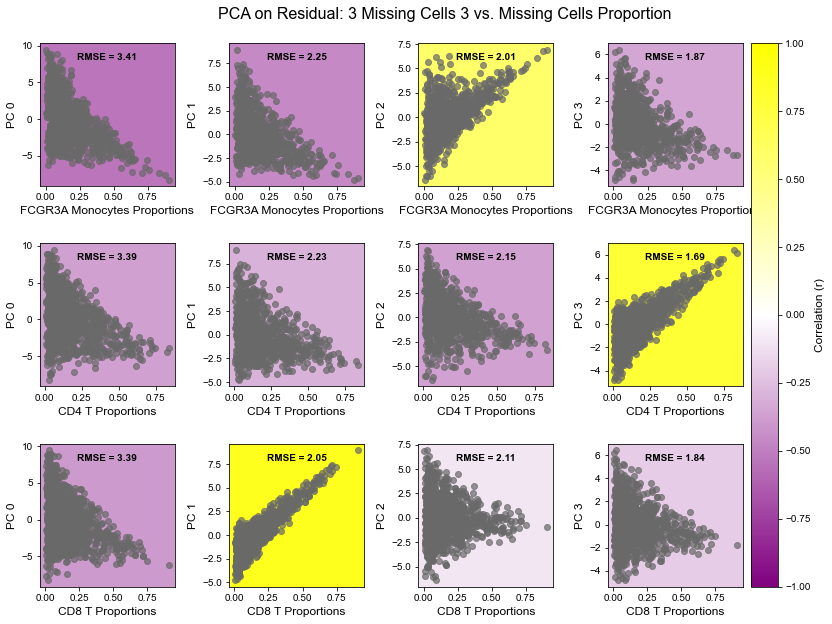

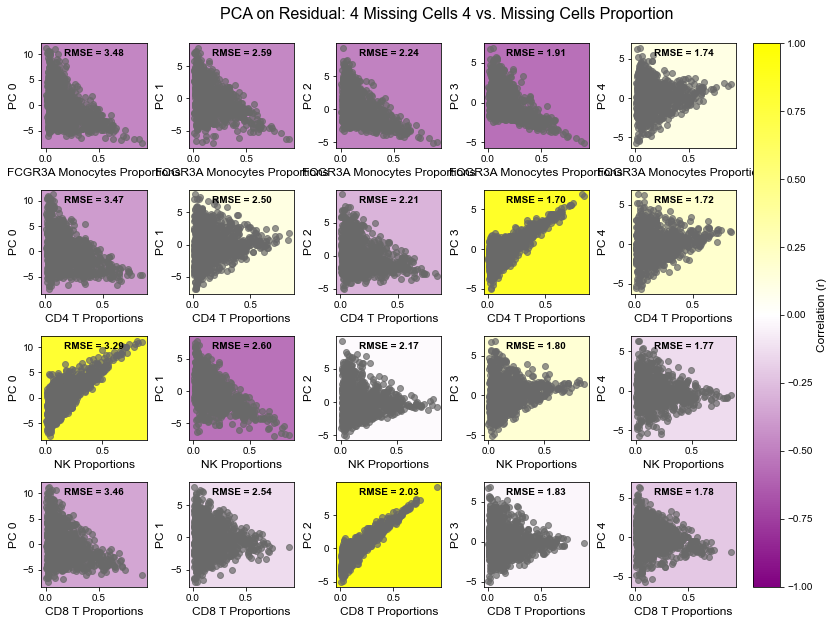

In [41]:
#PCA Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_pca_sample = dict()
for num in num_missing_cells[1:]:
    num_pca = num + 1
    pca = PCA(n_components = num_pca)
    res_pca_df = pca.fit_transform(residuals[num])
    res_pca_sample[num] = pd.DataFrame(res_pca_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_pca_sample, missing_cell_prop, num_cells_missing, "PCA")

## **ICA**

Calculate ICA

In [42]:
#ICA on residual 1
res_ica = dict()
for num in num_missing_cells:
    num_ica = num + 1
    ica = FastICA(n_components = num_ica)
    res_ica_df = ica.fit_transform(residuals[num].T)
    res_ica_df = pd.DataFrame(res_ica_df)
    res_ica[num] = res_ica_df

Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


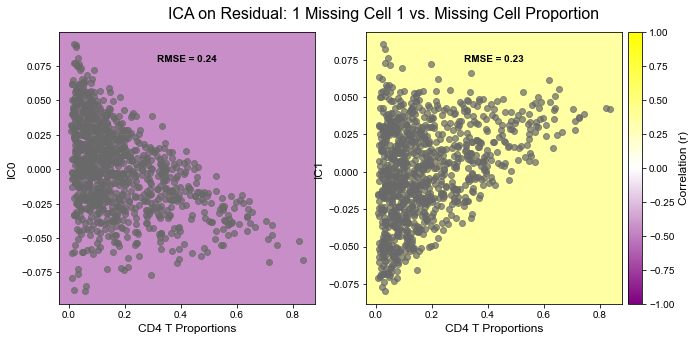

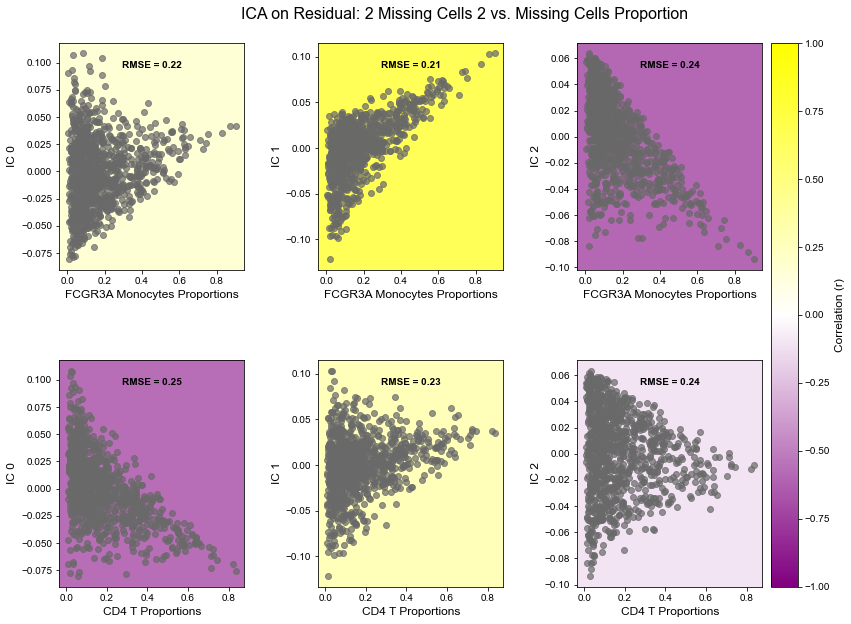

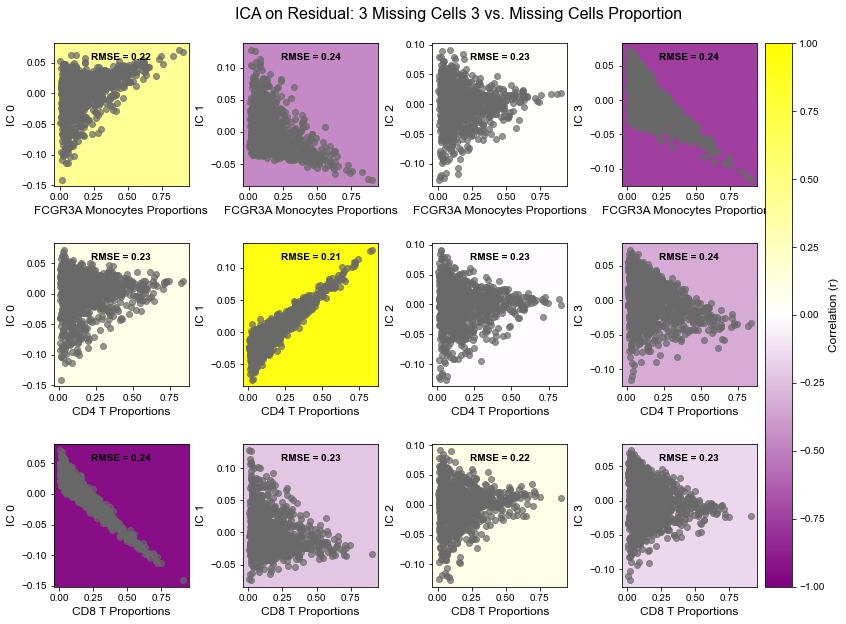

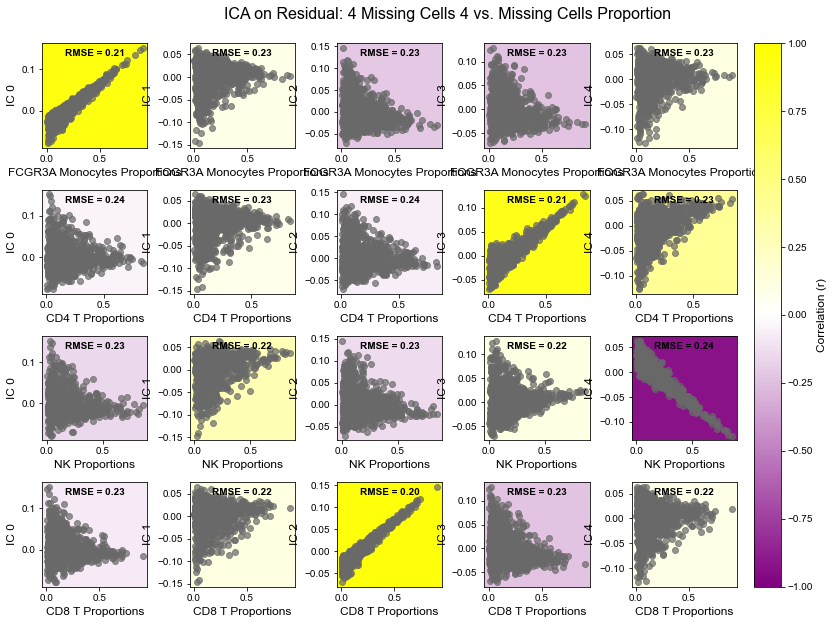

In [43]:
#ICA Residual (by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_ICA_sample = dict()
for num in num_missing_cells[1:]:
    num_ICA = num + 1
    ica = FastICA(n_components = num_ICA)
    res_ICA_df = ica.fit_transform(residuals[num])
    res_ICA_sample[num] = pd.DataFrame(res_ICA_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_ICA_sample, missing_cell_prop, num_cells_missing, "ICA")

## NMF

Analyzing how close to negative the distributions of each residual are:

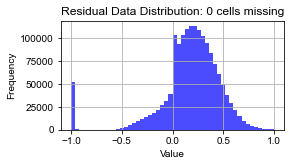

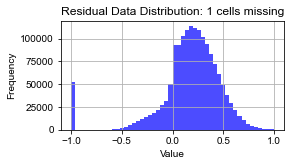

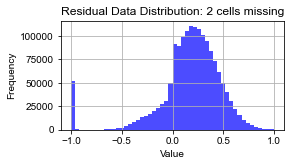

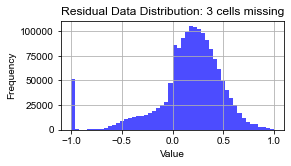

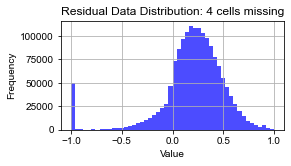

In [44]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9999999403953556


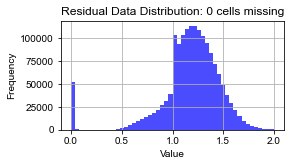

0.9999999403953556


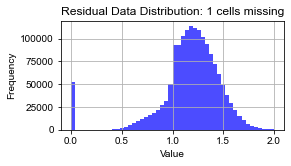

0.9999999403953554


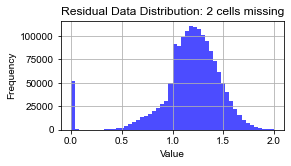

0.9999999403953554


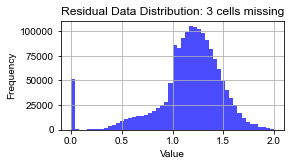

0.9999999403953554


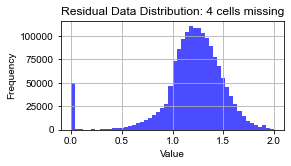

In [45]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Analyzing NMF Results:

Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


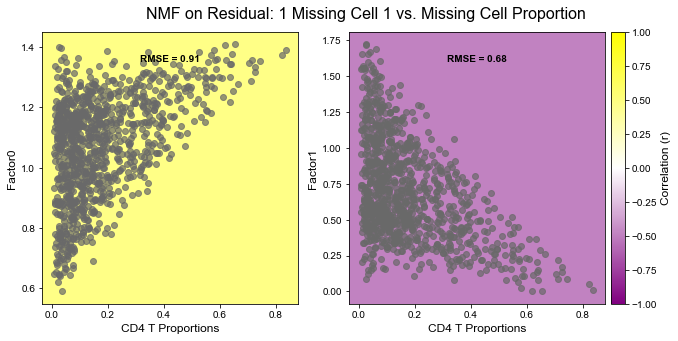

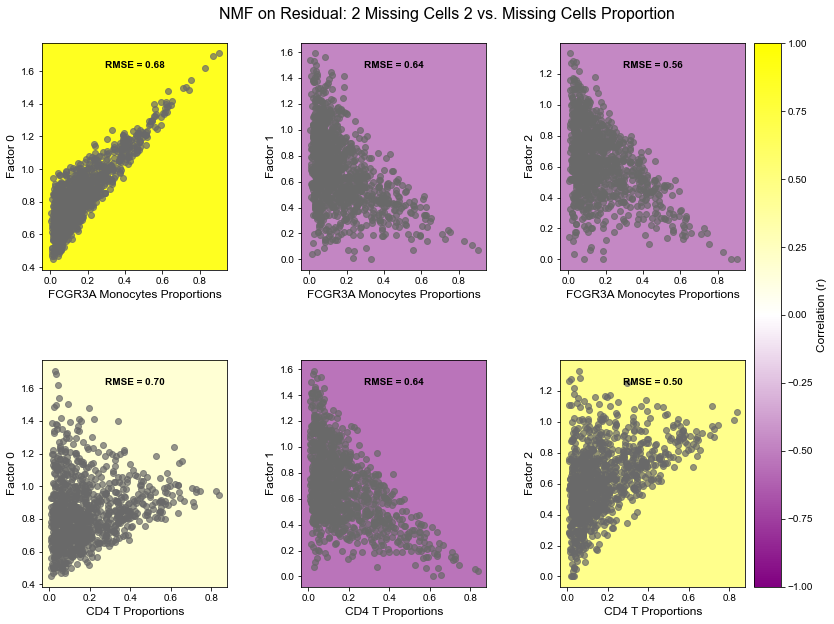

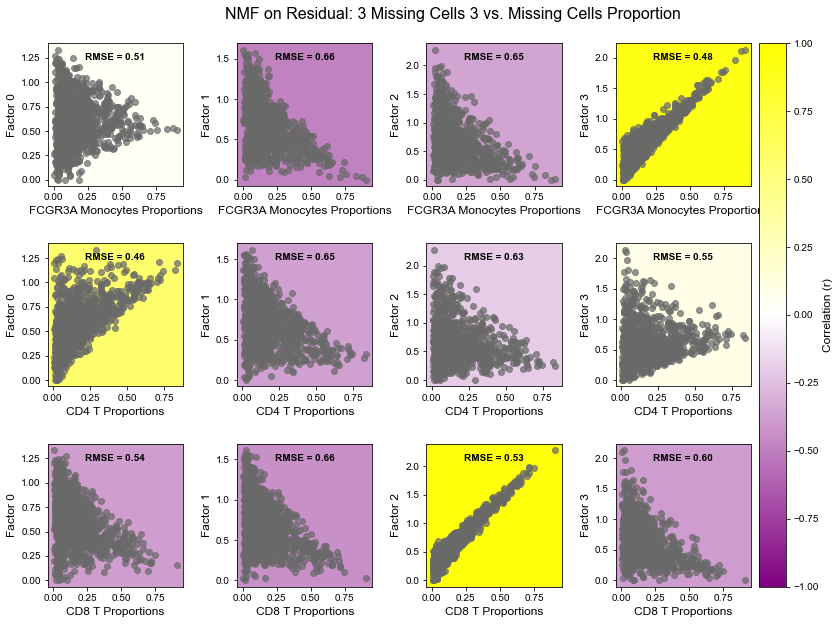

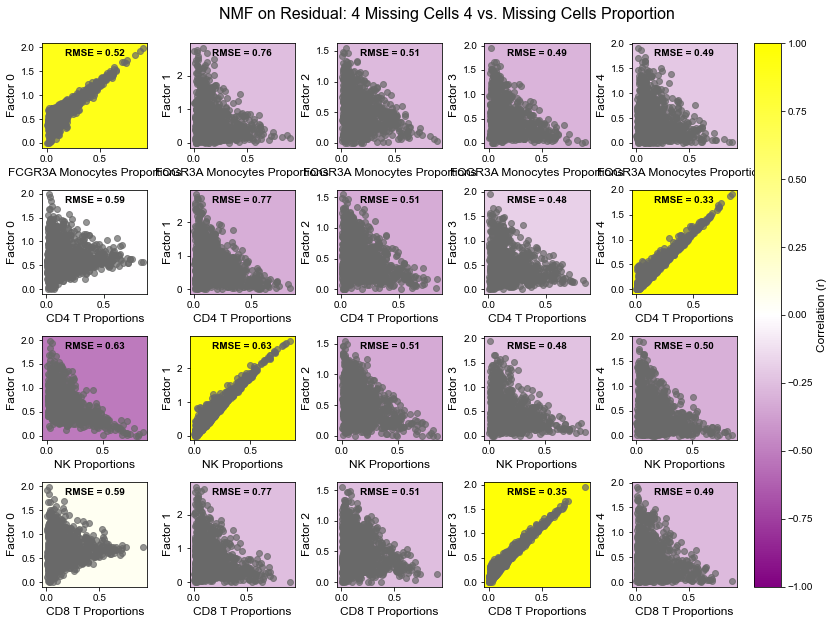

In [46]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


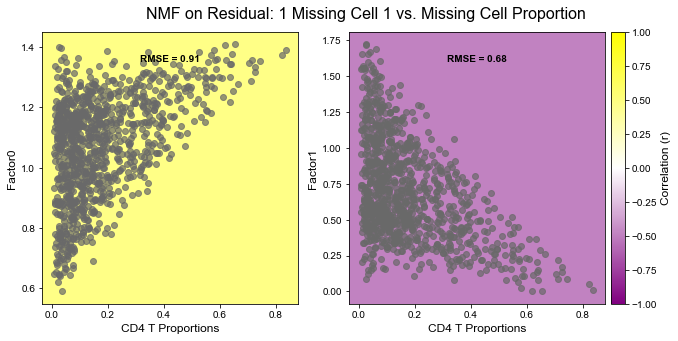

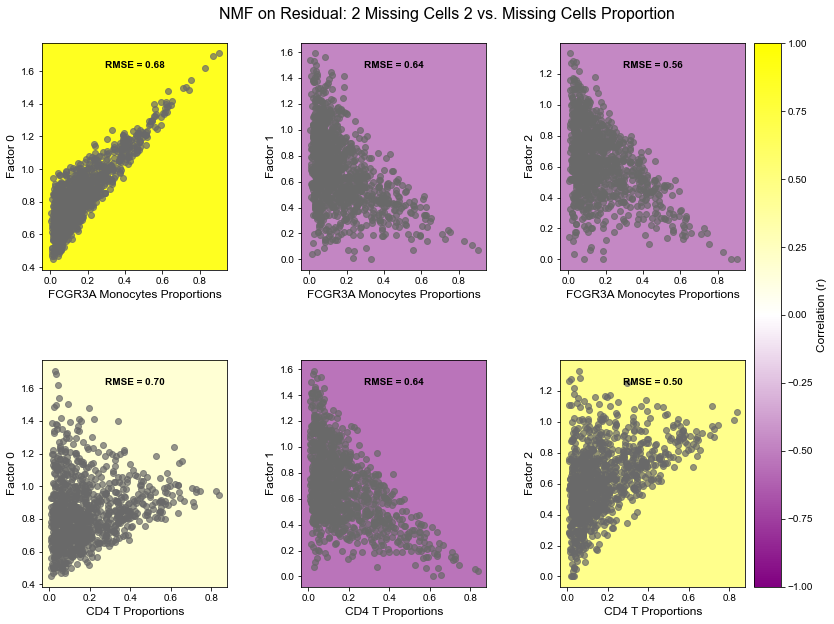

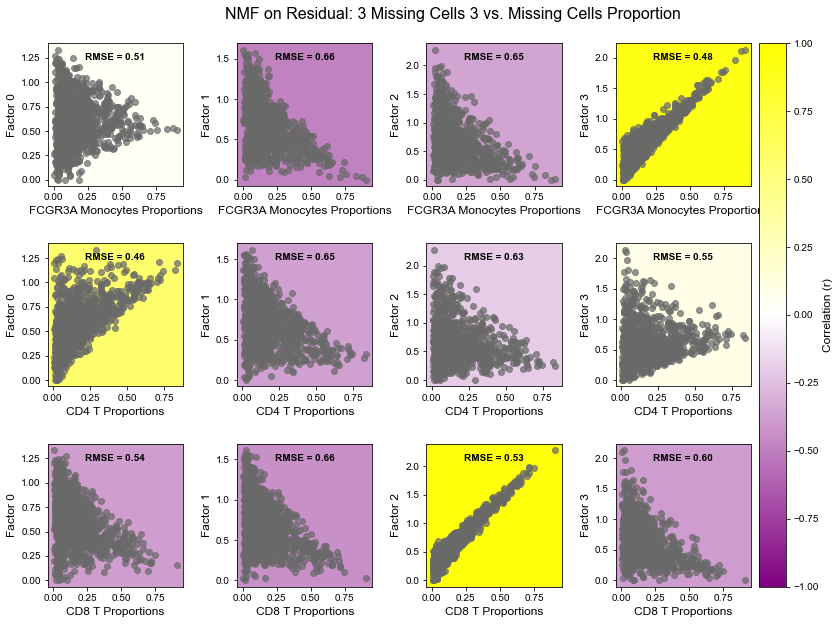

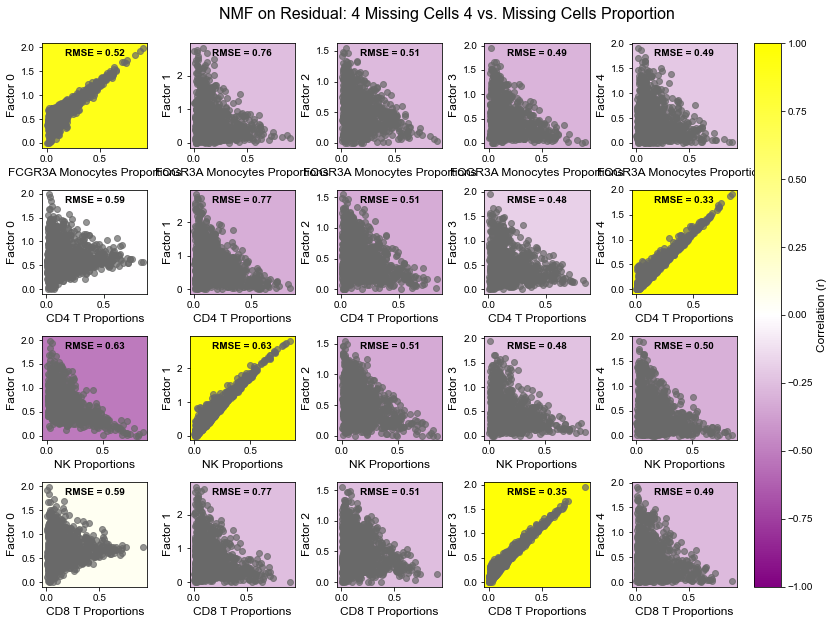

In [47]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 